In [29]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
plt.rcParams["figure.dpi"] = 120

In [31]:
data_dir = "../data"

In [40]:
# AG-Pubmed

dfs = [
    (
        "Bio Medical Llama 3",
        "Medicine",
        pd.concat(
            [
                pd.read_pickle(
                    f"{data_dir}/full/domainspecific_results_2529_medical-llama_4bit_rephrase_ag-pubmed.pkl"
                )[["prompt", "prompt_gradient", "label"]].rename(
                    columns={
                        "prompt_gradient": "uncertainty_after",
                    }
                ),
                pd.read_pickle(
                    f"{data_dir}/full/domainspecific_results_2531_llama-3-8b_4bit_rephrase_ag-pubmed.pkl"
                )[["prompt", "prompt_gradient", "label"]].rename(
                    columns={
                        "prompt": "prompt_before",
                        "prompt_gradient": "uncertainty_before",
                        "label": "label_before",
                    }
                ),
            ],
            axis=1,
        ),
    ),
    (
        "II Medical",
        "Medicine",
        pd.concat(
            [
                pd.read_pickle(
                    f"{data_dir}/full/domainspecific_results_2530_ii-medical_4bit_rephrase_ag-pubmed.pkl"
                )[["prompt", "prompt_gradient", "label"]].rename(
                    columns={
                        "prompt_gradient": "uncertainty_after",
                    }
                ),
                pd.read_pickle(
                    f"{data_dir}/full/domainspecific_results_2533_qwen2.5-7b-instruct_4bit_rephrase_ag-pubmed.pkl"
                )[["prompt", "prompt_gradient", "label"]].rename(
                    columns={
                        "prompt": "prompt_before",
                        "prompt_gradient": "uncertainty_before",
                        "label": "label_before",
                    }
                ),
            ],
            axis=1,
        ),
    ),
]

In [41]:
for _, __, df in dfs:
    df.dropna(
        subset=["uncertainty_before", "uncertainty_after"],
        inplace=True,
    )
    df["uncertainty_difference"] = df["uncertainty_after"] - df["uncertainty_before"]
    df["uncertainty_difference_relative"] = df["uncertainty_difference"] / df[
        "uncertainty_before"
    ].replace([np.inf, -np.inf], np.nan)
    df["uncertainty_ratio"] = (
        df["uncertainty_after"] / df["uncertainty_before"]
    ).replace([np.inf, -np.inf], np.nan)

In [42]:
dfs_melted = [
    (
        name,
        trained_label,
        df[["label", "uncertainty_before", "uncertainty_after"]].melt(
            id_vars=["label"],
            value_vars=["uncertainty_before", "uncertainty_after"],
            var_name="type",
            value_name="uncertainty",
        ),
    )
    for name, trained_label, df in dfs
]

In [43]:
for _, __, df_melted in dfs_melted:
    df_melted["type"] = df_melted["type"].map(
        {
            "uncertainty_before": "Before",
            "uncertainty_after": "After",
        }
    )

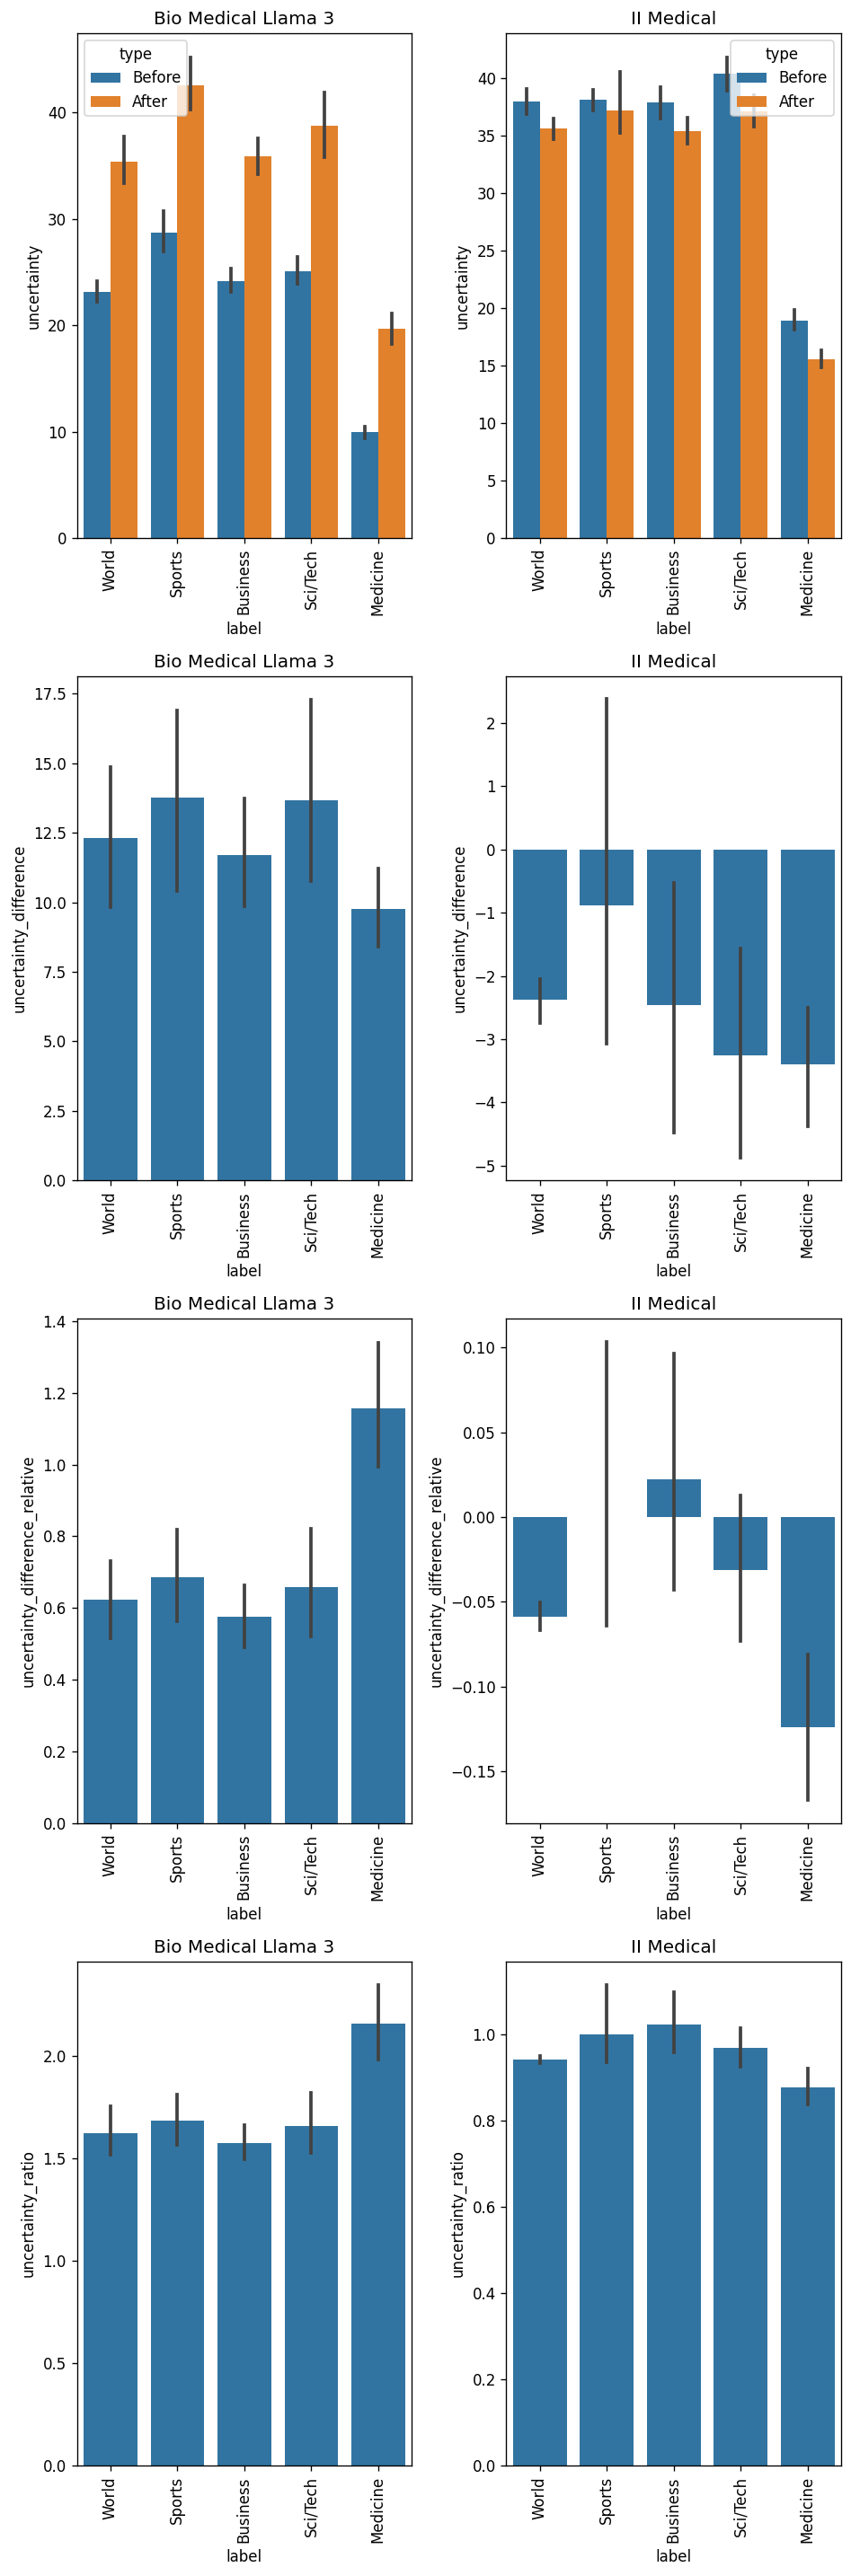

In [44]:
plt_width = 4
plt_height = 6

x_plots = len(dfs)
y_plots = 4

fig, axs = plt.subplots(
    y_plots,
    x_plots,
    figsize=(x_plots * plt_width, y_plots * plt_height),
    squeeze=False,
)

hue_colors = {
    "Before": "tab:blue",
    "After": "tab:orange",
}

for i in range(len(dfs)):
    name, trained_label, df = dfs[i]
    _, __, df_melted = dfs_melted[i]

    sns.barplot(data=df_melted, x="label", y="uncertainty", hue="type", ax=axs[0][i])
    sns.barplot(data=df, x="label", y="uncertainty_difference", ax=axs[1][i])
    sns.barplot(data=df, x="label", y="uncertainty_difference_relative", ax=axs[2][i])
    sns.barplot(data=df, x="label", y="uncertainty_ratio", ax=axs[3][i])

    for ax in axs.T[i]:
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_title(name)

plt.tight_layout()

In [45]:
def t_tests(dfs, metric):
    for name, trained_label, df in dfs:
        trained_group = df[df["label"] == trained_label][metric]
        other_groups = df[df["label"] != trained_label][metric]

        t_stat, p_value = ttest_ind(trained_group, other_groups, equal_var=False)

        print(
            f"{name:<10} {trained_label} vs Others T-statistic: {t_stat:>12.4f}, P-value: {p_value:.4f}"
        )
    
    print()

    for name, trained_label, df in dfs:
        trained_group = df[df["label"] == trained_label][metric]

        labels = df["label"].unique()

        for label in labels:
            if label != trained_label:
                other_group = df[df["label"] == label][metric]
                t_stat, p_value = ttest_ind(trained_group, other_group, equal_var=False)
                print(
                    f"{name:<10} {trained_label} vs {label:<10} T-statistic: {t_stat:>12.4f}, P-value: {p_value:.4f}"
                )

In [46]:
t_tests(dfs, "uncertainty_difference")

Bio Medical Llama 3 Medicine vs Others T-statistic:      -3.0022, P-value: 0.0028
II Medical Medicine vs Others T-statistic:      -1.6149, P-value: 0.1068

Bio Medical Llama 3 Medicine vs World      T-statistic:      -1.7501, P-value: 0.0811
Bio Medical Llama 3 Medicine vs Sports     T-statistic:      -2.2687, P-value: 0.0240
Bio Medical Llama 3 Medicine vs Business   T-statistic:      -1.5190, P-value: 0.1296
Bio Medical Llama 3 Medicine vs Sci/Tech   T-statistic:      -2.0896, P-value: 0.0376
II Medical Medicine vs World      T-statistic:      -1.9202, P-value: 0.0560
II Medical Medicine vs Sports     T-statistic:      -1.5464, P-value: 0.1233
II Medical Medicine vs Business   T-statistic:      -0.8655, P-value: 0.3874
II Medical Medicine vs Sci/Tech   T-statistic:      -0.1348, P-value: 0.8928


In [47]:
t_tests(dfs, "uncertainty_difference_relative")

Bio Medical Llama 3 Medicine vs Others T-statistic:       5.3501, P-value: 0.0000
II Medical Medicine vs Others T-statistic:      -3.8615, P-value: 0.0001

Bio Medical Llama 3 Medicine vs World      T-statistic:       4.9039, P-value: 0.0000
Bio Medical Llama 3 Medicine vs Sports     T-statistic:       4.1768, P-value: 0.0000
Bio Medical Llama 3 Medicine vs Business   T-statistic:       5.7196, P-value: 0.0000
Bio Medical Llama 3 Medicine vs Sci/Tech   T-statistic:       4.1173, P-value: 0.0000
II Medical Medicine vs World      T-statistic:      -2.8588, P-value: 0.0047
II Medical Medicine vs Sports     T-statistic:      -2.2630, P-value: 0.0244
II Medical Medicine vs Business   T-statistic:      -3.5195, P-value: 0.0005
II Medical Medicine vs Sci/Tech   T-statistic:      -2.8876, P-value: 0.0041


In [48]:
t_tests(dfs, "uncertainty_ratio")

Bio Medical Llama 3 Medicine vs Others T-statistic:       5.3501, P-value: 0.0000
II Medical Medicine vs Others T-statistic:      -3.8615, P-value: 0.0001

Bio Medical Llama 3 Medicine vs World      T-statistic:       4.9039, P-value: 0.0000
Bio Medical Llama 3 Medicine vs Sports     T-statistic:       4.1768, P-value: 0.0000
Bio Medical Llama 3 Medicine vs Business   T-statistic:       5.7196, P-value: 0.0000
Bio Medical Llama 3 Medicine vs Sci/Tech   T-statistic:       4.1173, P-value: 0.0000
II Medical Medicine vs World      T-statistic:      -2.8588, P-value: 0.0047
II Medical Medicine vs Sports     T-statistic:      -2.2630, P-value: 0.0244
II Medical Medicine vs Business   T-statistic:      -3.5195, P-value: 0.0005
II Medical Medicine vs Sci/Tech   T-statistic:      -2.8876, P-value: 0.0041
